### Implementing Term Frequency - Inverse Document Frequency (TF-IDF) with Multinomial Naive Bayes, Random Forest, and Logistic Regression

### Exploring the datasets

In [ ]:
!pip install tensorflow==2.16.1 # version 2.16.1
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

In [ ]:
!pip install -q keras-nlp --upgrade

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
#import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt


print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
#print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.1
Keras version: 0.1.7


In [ ]:
# Taking a look at the data files

DATA_DIR = '/content/drive/MyDrive/llm-detect-ai-generated-text/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/llm-detect-ai-generated-text/sample_submission.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/test_essays.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/train_essays.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/train_prompts.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/train_prompts(AutoRecovered).csv
/content/drive/MyDrive/llm-detect-ai-generated-text/train_essays(AutoRecovered).csv
/content/drive/MyDrive/llm-detect-ai-generated-text/train_v2_drcat_02.csv


In [ ]:
os.getcwd()
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df_train_prompts = pd.read_csv(DATA_DIR + "train_prompts.csv")
print(df_train_prompts.info())
df_train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [ ]:
df_train_essays = pd.read_csv(DATA_DIR + "train_essays.csv")
df_train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


Text(0.5, 1.0, 'Distribution of Generated Text')

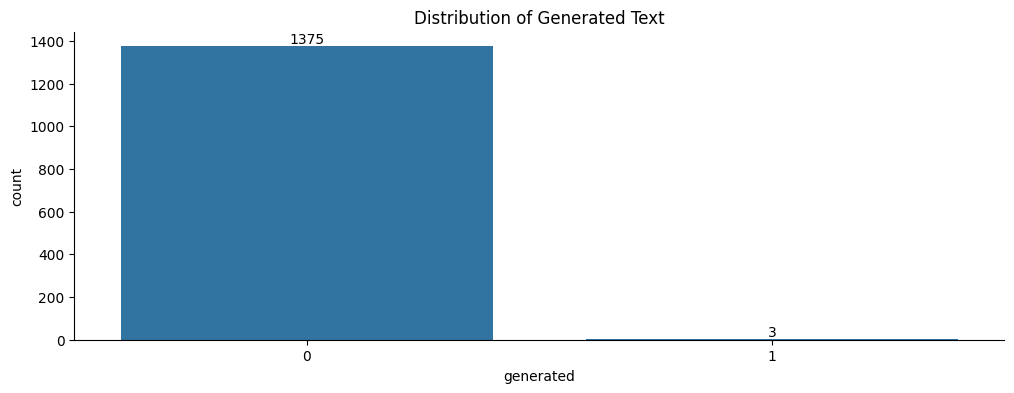

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays,
                   x="generated")

abs_values = df_train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [ ]:
# Adding new data to the training dataset
# Using dataset created by Darek Kleczek

df_train_essays_ext = pd.read_csv(DATA_DIR + 'train_v2_drcat_02.csv', encoding='utf-8')

df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

df_train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   generated      44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [ ]:
df_train_essays_ext.head()

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


Text(0.5, 1.0, 'Distribution of Generated Text')

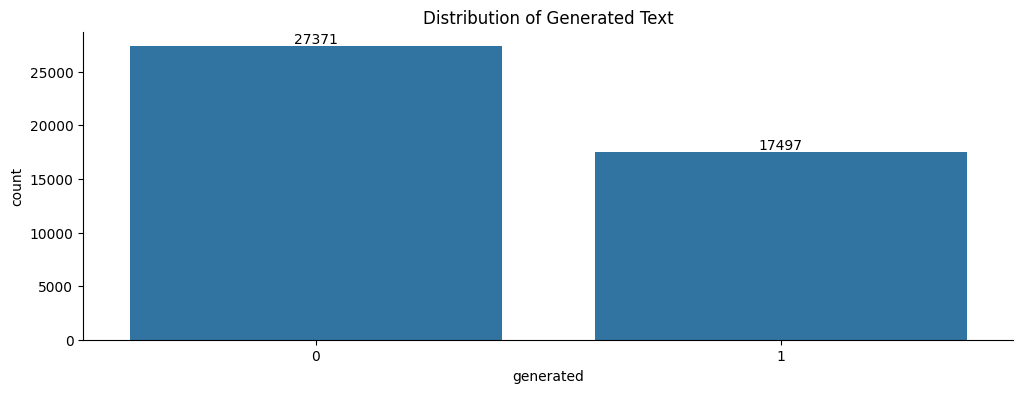

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="generated")

abs_values = df_train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

### Combining the datasets

In [ ]:
df_train_essays_final = pd.concat([df_train_essays_ext[["text", "generated"]], df_train_essays[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46246 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46246 non-null  object
 1   generated  46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Text(0.5, 1.0, 'Distribution of Generated Text')

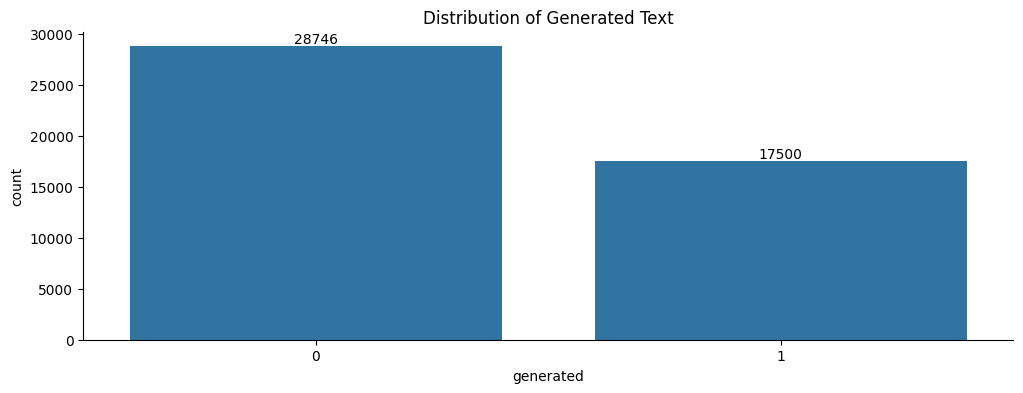

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated")

abs_values = df_train_essays_final['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [ ]:
# checking the length of the essays in the final dataset created

essays_length = []
essays_length = df_train_essays_final["text"].apply(lambda x : len(x.split()))

In [ ]:
essays_length.mean()

388.76142801539595

In [ ]:
essays_length.mean() + essays_length.std()

556.1289768295229

### Implementation of TF-IDF

In [ ]:
# Shuffling the data
shuffled_essays_data = df_train_essays_final.sample(frac=1, random_state=21)

In [ ]:
shuffled_essays_data.head()

,text,generated
24273,There is a debate today day about whether the ...,0
42892,"Dear Florida state senator, The Electoral Coll...",0
11042,The technology to read students emotions isn't...,0
22776,"Take classes Online can help busy students, bu...",0
42852,"Dear Senator, ""The Electoral College is a proc...",0


Text(0.5, 1.0, 'Distribution of Generated Text')

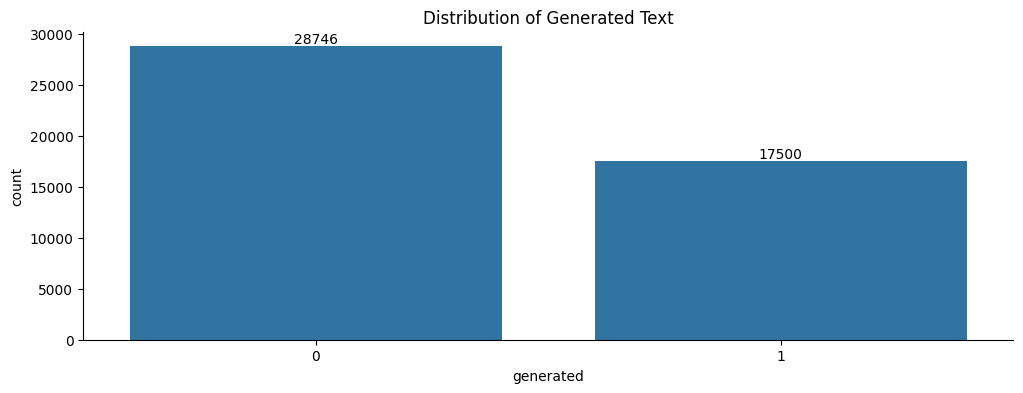

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(shuffled_essays_data,
                   x="generated")

abs_values = shuffled_essays_data['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
# Converting text to numerical form
X = vectorizer.fit_transform(shuffled_essays_data["text"])
Y = shuffled_essays_data["generated"]

In [ ]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.25,
                                                    )

In [ ]:
np.size(y_train)

34684

In [ ]:
counts = np.bincount(y_test)
number_of_zeros = counts[0]
number_of_ones = counts[1]

print(f"Number of 0s: {number_of_zeros}")
print(f"Number of 1s: {number_of_ones}")

Number of 0s: 7184
Number of 1s: 4378


### Multinomial NaiveBayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

classifier_NB = MultinomialNB()
classifier_NB.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Model Evaluation
y_pred = classifier_NB.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.94
Precision: 0.99
Recall: 0.86


### Random Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [ ]:
# Model Evaluation
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.95
Precision: 0.99
Recall: 0.89


In [ ]:
# Changing the number of tree and the criterion

classifier_gini = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier_gini.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = classifier_gini.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.98
Precision: 0.99
Recall: 0.95


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier_LR = LogisticRegression(random_state=0)
classifier_LR.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
y_pred = classifier_LR.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.99
Precision: 0.99
Recall: 0.98
